In [1]:
%matplotlib inline

## Pendulum: Custom environment with TorchRL and PyTorch Lightning

This notebook shows how to use TorchRL with PyTorch Lightning. The first part is almost straight up copy-paste from the [pendulum TorchRL tutorial](https://pytorch.org/rl/tutorials/pendulum.html) notebook. The second part shows how to use the same environment with PyTorch Lightning.

### Why TorchRL?
While `gym` is a great library, it may not be very flexible and has limitations (such as, need to run environments on CPU). This is where the new `torchrl` comes into play
- Batched environments
- Easy to use and extend. TensorDicts are a great way to handle data
- Can use in on GPU(s) and interface with PyTorch Lightning
- ...[and more](https://github.com/pytorch/rl)

### Why PyTorch Lightning?
- Faster development
- Easy to use
- Full of features: more science, less engineering
- ...[and more](https://github.com/Lightning-AI/lightning)

In [2]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

/home/botu/Dev/Sym-NCO/env/lib/python3.9/site-packages/torch/distributed/_shard/partial_tensor.py:40: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)
/home/botu/Dev/Sym-NCO/env/lib/python3.9/site-packages/torch/distributed/_shard/replicated_tensor.py:20: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)
/home/botu/Dev/Sym-NCO/env/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


## Making the custom environment

### Environment Step
This defines the state update of the pendulum gived a TensorDict  (`td` in the code) of the current state and the action to take:

In [3]:
DEFAULT_X = np.pi
DEFAULT_Y = 1.0

def _step(td):
    # td is shorthand for tensordict

    th, thdot = td["th"], td["thdot"]  # th := theta

    g_force = td["params", "g"]
    mass = td["params", "m"]
    length = td["params", "l"]
    dt = td["params", "dt"]
    u = td["action"].squeeze(-1)
    u = u.clamp(-td["params", "max_torque"], td["params", "max_torque"])
    costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)

    new_thdot = (
        thdot
        + (3 * g_force / (2 * length) * th.sin() + 3.0 / (mass * length**2) * u) * dt
    )
    new_thdot = new_thdot.clamp(
        -td["params", "max_speed"], td["params", "max_speed"]
    )
    new_th = th + new_thdot * dt
    reward = -costs.view(*td.shape, 1)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "th": new_th,
            "thdot": new_thdot,
            "params": td["params"],
            "reward": reward,
            "done": done,
        },
        td.shape,
    )

    return out


def angle_normalize(x):
    return ((x + torch.pi) % (2 * torch.pi)) - torch.pi

### Environment Reset

This defines the reset of the pendulum. It returns a `TensorDict` of the initial state:


In [4]:
def _reset(self, td):
    # td = tensordict
    if td is None or td.is_empty():
        # if no tensordict is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input tensordict contains all the relevant
        # parameters to get started.
        td = self.gen_params(batch_size=self.batch_size)


    high_th = torch.tensor(DEFAULT_X)#, device=device)
    high_thdot = torch.tensor(DEFAULT_Y)#, device=device)
    low_th = -high_th
    low_thdot = -high_thdot

    # for non batch-locked envs, the input tensordict shape dictates the number
    # of simulators run simultaneously. In other contexts, the initial
    # random state's shape will depend upon the environment batch-size instead.
    th = (
        torch.rand(td.shape, generator=self.rng)# , device=device)
        * (high_th - low_th)
        + low_th
    )
    thdot = (
        torch.rand(td.shape, generator=self.rng) #, device=device)
        * (high_thdot - low_thdot)
        + low_thdot
    )
    out = TensorDict(
        {
            "th": th,
            "thdot": thdot,
            "params": td["params"],
        },
        batch_size=td.shape,
    )
    return out

### Environment metadata
This defines the input and output domains of the environment - similar to `gym`'s `spaces`:

In [5]:
def _make_spec(self, td_params):
    self.observation_spec = CompositeSpec(
        th=BoundedTensorSpec(
            minimum=-torch.pi,
            maximum=torch.pi,
            shape=(),
            dtype=torch.float32,
        ),
        thdot=BoundedTensorSpec(
            minimum=-td_params["params", "max_speed"],
            maximum=td_params["params", "max_speed"],
            shape=(),
            dtype=torch.float32,
        ),
        # we need to add the "params" to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),#.to(self.device)),
        shape=(),
        # device=self.device,
    )
    # since the environment is stateless, we expect the previous output as input
    self.input_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in input_spec, but the convenient
    # self.action_spec = spec is supported
    self.action_spec = BoundedTensorSpec(
        minimum=-td_params["params", "max_torque"],
        maximum=td_params["params", "max_torque"],
        shape=(1,),
        dtype=torch.float32,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom funtion to convert a tensordict in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, shape=tensor.shape #device=tensor.device, 
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

### Seeding for reproducible experiments

In [6]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

### Parameter generation
This function deterministically generates the parameters for the environment:

In [7]:
def gen_params(g=10.0, batch_size=None) -> TensorDictBase:
    """Returns a tensordict containing the physical parameters such as gravitational force and torque or speed limits."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "max_speed": 8,
                    "max_torque": 2.0,
                    "dt": 0.05,
                    "g": g,
                    "m": 1.0,
                    "l": 1.0,
                },
                [],
            )
        },
        [],
        # device=device
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

### Environment creation
Here we use `EnvBase` to create the environment similarly to `gym`:

In [8]:
class PendulumEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()
        
        # print(td_params)

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    def state_dict(self, *args, **kwargs):
        pass # we set this function for compatibility

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed


### Testing the environment

In [9]:
env = PendulumEnv()
check_env_specs(env)

check_env_specs succeeded!


In [10]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        th: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        thdot: Tensor

In [11]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                        max_torque: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=F

### Transforms

We can apply transforms to the environment for stacking dimensions or creating new states:

In [12]:
env = TransformedEnv(
    env,
    # Unsqueezes the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=-1,
        in_keys=["th", "thdot"],
        in_keys_inv=["th", "thdot"],
    ),
)

In [13]:
class SinTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.sin()

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            minimum=-1,
            maximum=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            # device=observation_spec.device,
        )


class CosTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.cos()

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            minimum=-1,
            maximum=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            # device=observation_spec.device,
        )


t_sin = SinTransform(in_keys=["th"], out_keys=["sin"])
t_cos = CosTransform(in_keys=["th"], out_keys=["cos"])
env.append_transform(t_sin)
env.append_transform(t_cos)

Concatenates the observations onto an "observation" entry.
del_keys=False ensures that we keep these values for the next
iteration.



In [14]:
cat_transform = CatTensors(
    in_keys=["sin", "cos", "thdot"], dim=-1, out_key="observation", del_keys=False
)
env.append_transform(cat_transform)

Once more, let us check that our env specs match what is received:



In [15]:
check_env_specs(env)

check_env_specs succeeded!


### Executing a simple rollout

In [16]:
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

data from rollout: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=F

### Batching computations

In [17]:
batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

reset (batch size of 10) TensorDict(
    fields={
        cos: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float3

In [18]:
rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

rollout of len 3 (batch size of 10): TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([10, 3]), device=cpu

### Creating a simple policy

We use a simple MLP policy. We wrap it in a `TensorDictModule` to make it compatible with `torchrl`'s `TensorDict` data format:

In [19]:
torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)

policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

/home/botu/Dev/Sym-NCO/env/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Build TorchDict Dataset

We generally need a dataloader for PyTorch Lightning. We can create a `TorchDictDataset` as follows:

In [20]:
class TorchDictDataset(Dataset):
    def __init__(self, data):
        # Note that we are using list comprehension here
        # since it looks like self.data[idx] does not work otherwise
        # we finally need to add the `torch.stack` collate_fn
        self.data = [d for d in data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

### Hyperparameters

We emulate epochs by setting a number of batches per epoch:

In [21]:
batch_size = 32
batches_per_epoch = 512 # how many batches to sample per epoch
epochs = 30 
lr = 2e-3 # same as TorchRL's tutorial
rollout_len = 100 # how many steps to rollout with the policy
total_steps = batches_per_epoch * epochs // batch_size
print(f"Total number of gradient steps: {total_steps}")

Total number of gradient steps: 480


### (Optional) Dummy forward pass

It looks like we need this when using multiple GPUs to avoid this error, not sure how to make it work without this:

```RuntimeError: Modules with uninitialized parameters can't be used with `DistributedDataParallel`. Run a dummy forward pass to correctly initialize the modules```

In [22]:
data = env.gen_params(batch_size=batch_size)
init_td = env.reset(data)
rollout = env.rollout(100, policy, tensordict=init_td, auto_reset=False)    

### Lightning module

This is a simple implementation of a PyTorch Lightning module. We include both the `env` and the `policy` as part of the module:

In [23]:
class RLLightningModule(pl.LightningModule):
    def __init__(self, env, policy):
        super().__init__()
        self.env = env
        self.policy = policy

    def training_step(self, batch, batch_idx):
        rollout = self.env.rollout(rollout_len, self.policy, tensordict=batch, auto_reset=False)       
        traj_return = rollout["reward"].mean()
        loss = -traj_return
        self.log("reward", traj_return, prog_bar=True)
        self.log("last reward", rollout[..., -1]['reward'].mean(), prog_bar=True)
        return {"loss": loss}

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.policy.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
        return [optim], [scheduler]
    
    def train_dataloader(self):
        return self._dataloader()
    
    def on_fit_start(self):
        self._generate_data()
    
    def on_train_epoch_end(self):
        self._generate_data()

    def _generate_data(self):
        # Online data generation: we generate a new batch every epoch
        data = self.env.gen_params(batch_size=batches_per_epoch)
        init_td = self.env.reset(data)
        self.dataset = TorchDictDataset(init_td)
           
    def _dataloader(self): 
        return DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=False, # no need to shuffle, we're resampling every epoch
            num_workers=0,
            collate_fn=torch.stack, # we need this to stack the batches in the dataset
        )

### Fit the model

Here is the main training loop! It is customizable in many ways. In this example, we train on two GPUs:

In [24]:
# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Wandb Logger - we can use others as well as simply `None`
# logger = pl.loggers.WandbLogger(project="torchrl", name="pendulum")
logger = pl.loggers.CSVLogger("logs", name="pendulum")

# Instantiate the module
model = RLLightningModule(env, policy)

# Trainer
trainer = pl.Trainer(
    max_epochs= epochs,
    num_nodes=1,
    devices=2,
    accelerator="cuda",
    logger=logger,
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
)

# Fit the model
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type             | Params
--------------------------------------------
0 | env    | TransformedEnv   | 0     
1 | policy | TensorDictModule | 8.6 K 
--------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
/home/botu/Dev/Sym-NCO

Epoch 0:  12%|█▎        | 1/8 [00:00<00:05,  1.23it/s, loss=6.25, v_num=9, reward=-6.25, last reward=-6.58]

[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 29: 100%|██████████| 8/8 [00:02<00:00,  3.77it/s, loss=3.26, v_num=9, reward=-4.39, last reward=-5.05]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 8/8 [00:02<00:00,  3.66it/s, loss=3.26, v_num=9, reward=-4.39, last reward=-5.05]


### Plot results

Text(0.5, 0, 'Step')

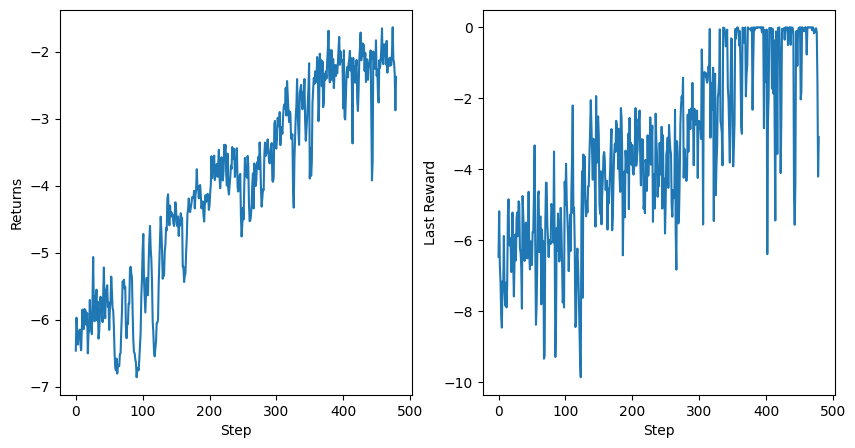

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# This plotting is for CSV logger - might not work with DataParallel
# You may use another logger such as WandbLogger
root_dir = logger.log_dir
csv_file = glob.glob(os.path.join(root_dir, "*.csv"))[0]
df = pd.read_csv(csv_file)
df.head()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(df["step"], df["reward"], label="reward")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Returns")
axs[1].plot(df["step"], df["last reward"], label="last reward")
axs[1].set_ylabel("Last Reward")
axs[1].set_xlabel("Step")